In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import os
import torchvision.transforms as transforms
import torchvision.datasets as dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy

from saga import SAGA
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)
    
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
train_set = dataset.MNIST(root=root, train=True, transform = transform, download=True)
#test_set = dataset.MNIST(root=root, train=False, transform= transform, download=True)


train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=train_set.train_data.shape[0],
                 shuffle=True)
#test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=test_set.test_data.shape[0],shuffle=False)
X_train, y_train = list(train_loader)[0][0][:1000], list(train_loader)[0][1][:1000]
#X_test, y_test = list(test_loader)[0][0],list(test_loader)[0][1]

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
def plot_loss(losses, labels):
    plt.figure(figsize=(15,5))
    for losses, label in zip(losses, labels):
        plt.plot(losses, label = label)
    plt.legend(loc='upper right')
    plt.title('training loss')
    plt.xlabel('iteration*100')
    plt.ylabel('loss')

In [6]:
X_train.shape[0]

1000

In [7]:
model_GD = Net()
model_SGD = Net()
model_SAGA = Net()
model_GD_losses = []
model_SGD_losses = []
model_SAGA_losses = []


criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer_GD = torch.optim.SGD(model_GD.parameters(), lr = lr)
optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr = lr)
optimizer_SAGA = SAGA(model_SAGA.parameters(),model_SAGA, X_train.shape[0], lr = lr)

n_epochs = 20000

#train GD
for epoch in range(n_epochs):    
    outputs = model_GD.forward(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer_GD.step()
    if epoch % 100 == 0:
        model_GD_losses.append(loss.data.item())
    optimizer_GD.zero_grad()

In [8]:
#train SGD
for epoch in range(n_epochs):
    idx = np.random.randint(X_train.shape[0])  # get random sample index
    inputs = X_train[idx].view(1,X_train[idx].shape[0],X_train[idx].shape[1],X_train[idx].shape[2]).to(device)
    labels = y_train[idx].view(1).to(device)

    outputs = model_SGD.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer_SGD.step()
    if epoch % 100 == 0:
        inputs_loss_plot = X_train.to(device)
        labels_loss_plot = y_train.to(device)
        outputs_loss_plot = model_SGD.forward(inputs_loss_plot)
        loss_plot = criterion(outputs_loss_plot, labels_loss_plot)
        model_SGD_losses.append(loss_plot.data.item())
    optimizer_SGD.zero_grad()

In [9]:
#train SAGA
for epoch in range(n_epochs):
    idx = np.random.randint(X_train.shape[0])  # get random sample index
    inputs = X_train[idx].view(1,X_train[idx].shape[0],X_train[idx].shape[1],X_train[idx].shape[2]).to(device)
    labels = y_train[idx].view(1).to(device)

    outputs = model_SAGA.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    closure = idx
    optimizer_SAGA.step(closure)
    if epoch % 100 == 0:
        inputs_loss_plot = X_train.to(device)
        labels_loss_plot = y_train.to(device)
        outputs_loss_plot = model_SAGA.forward(inputs_loss_plot)
        loss_plot = criterion(outputs_loss_plot, labels_loss_plot)
        model_SAGA_losses.append(loss_plot.data.item())
    optimizer_SAGA.zero_grad()

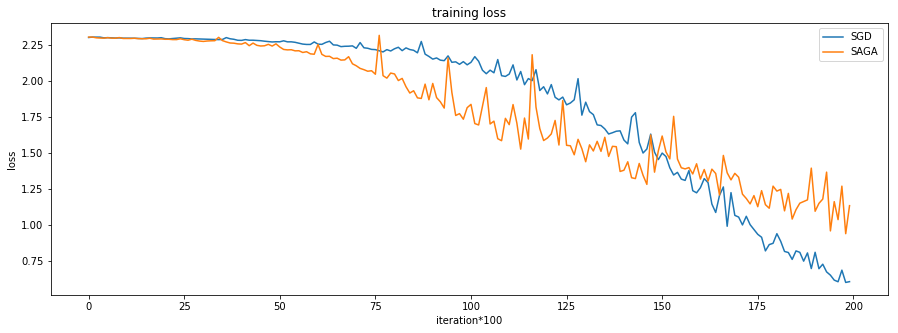

In [10]:
#SGD becomes better than SAGA
plot_loss([model_SGD_losses,model_SAGA_losses], ['SGD','SAGA'])